<a href="https://colab.research.google.com/github/RaisaAnika/model-confidence_CIFAR10/blob/main/CIS545_Fall22_ModelConfidence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 Model and Some Useful Starter Code

This starter code is to help you have a CIFAR-10 model that is trained on the whole dataset. You will also find some helper functions for splitting the dataset into $n$ disjoint sets (from which you can train individual models that will serve in the ensemble).

The CIFAR10 dataset contains 60K color images in 10 classes, with 6K images in each class. The dataset is divided into 50K training images and 10K testing images. The classes are mutually exclusive and there is no overlap between them. The 10 classes are ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck'].




In [3]:
!pip install tensorflow_privacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 301 kB 4.7 MB/s 
     |████████████████████████████████| 89 kB 7.9 MB/s 
     |████████████████████████████████| 12.2 MB 13.4 MB/s 
     |████████████████████████████████| 60 kB 8.3 MB/s 
     |████████████████████████████████| 5.7 MB 50.0 MB/s 
     |████████████████████████████████| 9.4 MB 43.0 MB/s 
     |████████████████████████████████| 126 kB 47.4 MB/s 
     |████████████████████████████████| 295 kB 50.1 MB/s 
     |████████████████████████████████| 965 kB 40.4 MB/s 
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.3.0
    Uninstalling absl-py-1.3.0:
      Successfully uninstalled absl-py-1.3.0
  Attempting uninstall: attrs
    Found existing installation: attrs 22.1.0
    Uninstalling attrs-22.1.0:
      Successfully uninstalled attrs-22.1.0
  Attempting uninstall: tensorflow-probability
    Found existing installati

In [4]:
!pip install tensorflow-privacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Library Imports

In [1]:
import tensorflow as tf
from keras.models import Model   
from keras.layers import *
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tensorflow.keras.models import Sequential


import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, GlobalAveragePooling2D, \
Dense, Input, Activation, MaxPool2D
from tensorflow.keras import Model

import sklearn.metrics

from numpy.random import default_rng
rng = default_rng()
AUTO = tf.data.AUTOTUNE

In [5]:
###Tensorflow attack libraries

from tensorflow_privacy.privacy.membership_inference_attack import membership_inference_attack as mia
#from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack as mia 
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.membership_inference_attack.data_structures import AttackType

/usr/local/lib/python3.8/dist-packages/tensorflow_privacy/privacy/membership_inference_attack/__init__.py:18: UserWarning: 
Membership inference attack sources were moved. Please replace
import tensorflow_privacy.privacy.membership_inference_attack

with
import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack
  warnings.warn(


# Load Dataset - CIFAR 10

In [6]:
# download CIFAR-10 dataset and split it into train and test set
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()


170498071/170498071 [==============================] - 2s 0us/step


In [7]:
print(x_train.shape[0])

50000


In [8]:
print(x_test.shape[0])

10000


In [9]:
print(y_train)

[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


In [10]:
# normalze pixel values to be in the range [0,1] instead of [0, 255]
x_train, x_test= x_train/ 255.0, x_test / 255.0



In [11]:
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 4.6 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.2
    Uninstalling matplotlib-3.6.2:
      Successfully uninstalled matplotlib-3.6.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-privacy 0.8.7 requires matplotlib~=3.3, but you have matplotlib 3.1.3 which is incompatible.


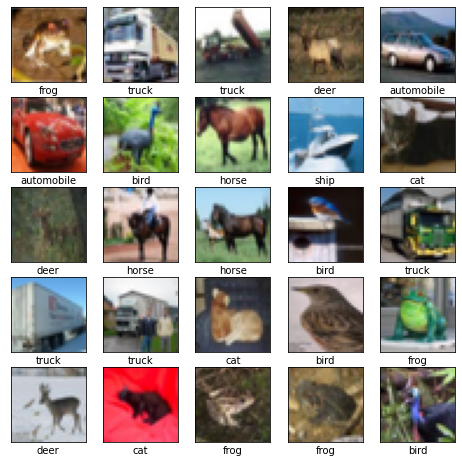

In [14]:
# let's check what individual samples in the training data look like just for verification

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(labels[y_train[i][0]])
plt.show()



# Machine Learning Model

In [15]:
def define_model():
  """ This model is fairly simple, feel free to play with this part in pursuit of a better accuracy architecture.
  """
  shape = (32, 32, 3)
  input = Input(shape=shape)
  x = Conv2D(32, (3, 3), activation='relu')(input)
  x = MaxPooling2D()(x)

  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPooling2D()(x)

  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = MaxPooling2D()(x)

  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)
  x = Dense(10)(x)
  model = Model(input, x)
  return model

In [16]:
model = define_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928 

In [ ]:
# def AlexnetModel(input_shape,num_classes):
#     model = Sequential()
# # model.add(Conv2D(96, (11,11), strides=(4,4), activation='relu', padding='same', input_shape=(img_height, img_width, channel,)))
# # for original Alexnet
#     model.add(Conv2D(48, (3,3), strides=(2,2), activation='relu', padding='same', input_shape=input_shape))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
# # Local Response normalization for Original Alexnet
#     model.add(BatchNormalization())

#     model.add(Conv2D(96, (3,3), activation='relu', padding='same'))
#     model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
# # Local Response normalization for Original Alexnet
#     model.add(BatchNormalization())

#     model.add(Conv2D(192, (3,3), activation='relu', padding='same'))
#     model.add(Conv2D(192, (3,3), activation='relu', padding='same'))
#     model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
#     model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
# # Local Response normalization for Original Alexnet
#     model.add(BatchNormalization())

#     model.add(Flatten())
#     model.add(Dense(512, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(256, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(num_classes, activation='softmax'))
#     return model

In [ ]:
# shape = (32, 32, 3)
# num_class=10
# learning_rate=.01
#   # epochs=60
#   # M=5

In [ ]:
# model1 = AlexnetModel(shape,num_class)
# model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 48)        1344      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 48)         0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 48)         192       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 96)          41568     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 96)         0         
 2D)                                                             
                                                        

In [ ]:
# check model summary
model = define_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 64)          36928 

# Generating Subset of the Dataset

In [17]:
##divide xtrain n ytrain to 5 DISJOINT subsets
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical


M=5 ##defining the desired no. of subsets

X=x_train
Y=y_train
for i in range(0,M):
  K=M-i
  if(K>=2):
    train=X
    test=Y
    skf = StratifiedKFold(n_splits=K)
    skf.get_n_splits(X, Y)
    #print(skf)
    for train_index, test_index in skf.split(X, Y):
       #print(X.shape)
       X,globals()['x_train_split%s' % i]=train[train_index], train[test_index]
       Y,globals()['trainy_split%s' % i]=test[train_index], test[test_index]
       y_hot=globals()['trainy_split%s' % i]
       y_hot=to_categorical(y_hot)
       globals()['y_train_split%s' % i]=y_hot
       #X=train
       #Y=test
  elif K==1:
    globals()['x_train_split%s' % i]=X
    globals()['trainy_split%s' % i]=Y
    y_hot=to_categorical(Y)
    globals()['y_train_split%s' % i]=y_hot

In [18]:
## 5 disjoint set of the train data
d1_data = x_train_split0
d1_label = trainy_split0
d2_data= x_train_split1
d2_label=trainy_split1
d3_data= x_train_split2
d3_label=trainy_split2
d4_data= x_train_split3
d4_label=trainy_split3
d5_data= x_train_split4
d5_label=trainy_split4

In [19]:
d1_data.shape

(10000, 32, 32, 3)

In [20]:
d1_label.shape

(10000, 1)

In [ ]:
skf.split(X, Y)

<generator object _BaseKFold.split at 0x7f812b30f4d0>

# Model Tuning

In [21]:
# specify parameters for model
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])



In [ ]:
# # specify parameters for model1
# optimizer = tf.keras.optimizers.Adam()
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# # compile the model1
# model1.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

## Model Training on subset 1

In [23]:
## fitting d1

# train the model with d1
history = model.fit(d1_data, d1_label,
                       validation_data=(x_test, y_test),
                       batch_size=128, 
                       epochs=5)
history

Epoch 1/5
79/79 [==============================] - 18s 208ms/step - loss: 2.0677 - accuracy: 0.2341 - val_loss: 1.9226 - val_accuracy: 0.2919
Epoch 2/5
79/79 [==============================] - 16s 206ms/step - loss: 1.7695 - accuracy: 0.3511 - val_loss: 1.7169 - val_accuracy: 0.3671
Epoch 3/5
79/79 [==============================] - 18s 226ms/step - loss: 1.6481 - accuracy: 0.3909 - val_loss: 1.7164 - val_accuracy: 0.3754
Epoch 4/5
79/79 [==============================] - 21s 273ms/step - loss: 1.5284 - accuracy: 0.4397 - val_loss: 1.5004 - val_accuracy: 0.4478
Epoch 5/5
79/79 [==============================] - 19s 243ms/step - loss: 1.4480 - accuracy: 0.4717 - val_loss: 1.4211 - val_accuracy: 0.4858


## Model Training on subset 2

In [24]:
## fitting d2

# train the model with d2
history2 = model.fit(d2_data, d2_label,
                       validation_data=(x_test, y_test),
                       batch_size=128, 
                       epochs=5)
history2

Epoch 1/5
79/79 [==============================] - 22s 278ms/step - loss: 1.4673 - accuracy: 0.4683 - val_loss: 1.3905 - val_accuracy: 0.5004
Epoch 2/5
79/79 [==============================] - 19s 242ms/step - loss: 1.3948 - accuracy: 0.4914 - val_loss: 1.4382 - val_accuracy: 0.4994
Epoch 3/5
79/79 [==============================] - 19s 241ms/step - loss: 1.3169 - accuracy: 0.5237 - val_loss: 1.3085 - val_accuracy: 0.5276
Epoch 4/5
79/79 [==============================] - 18s 222ms/step - loss: 1.2615 - accuracy: 0.5512 - val_loss: 1.3154 - val_accuracy: 0.5368
Epoch 5/5
79/79 [==============================] - 18s 228ms/step - loss: 1.2144 - accuracy: 0.5692 - val_loss: 1.2347 - val_accuracy: 0.5631


In [25]:
## fitting d3

# train the model with d3
history3 = model.fit(d3_data, d3_label,
                       validation_data=(x_test, y_test),
                       batch_size=128, 
                       epochs=5)
history3

Epoch 1/5
79/79 [==============================] - 18s 233ms/step - loss: 1.2509 - accuracy: 0.5506 - val_loss: 1.2050 - val_accuracy: 0.5682
Epoch 2/5
79/79 [==============================] - 17s 211ms/step - loss: 1.1770 - accuracy: 0.5810 - val_loss: 1.2205 - val_accuracy: 0.5680
Epoch 3/5
79/79 [==============================] - 17s 219ms/step - loss: 1.1220 - accuracy: 0.6009 - val_loss: 1.2422 - val_accuracy: 0.5534
Epoch 4/5
79/79 [==============================] - 17s 210ms/step - loss: 1.0880 - accuracy: 0.6118 - val_loss: 1.2137 - val_accuracy: 0.5764
Epoch 5/5
79/79 [==============================] - 16s 209ms/step - loss: 1.0484 - accuracy: 0.6289 - val_loss: 1.1380 - val_accuracy: 0.5981


In [26]:
## fitting d4

# train the model with d4
history4 = model.fit(d4_data, d4_label,
                       validation_data=(x_test, y_test),
                       batch_size=128, 
                       epochs=5)
history4

Epoch 1/5
79/79 [==============================] - 17s 214ms/step - loss: 1.1660 - accuracy: 0.5882 - val_loss: 1.1452 - val_accuracy: 0.5959
Epoch 2/5
79/79 [==============================] - 18s 226ms/step - loss: 1.1001 - accuracy: 0.6158 - val_loss: 1.1215 - val_accuracy: 0.5972
Epoch 3/5
79/79 [==============================] - 18s 231ms/step - loss: 1.0513 - accuracy: 0.6308 - val_loss: 1.1124 - val_accuracy: 0.6077
Epoch 4/5
79/79 [==============================] - 17s 211ms/step - loss: 1.0154 - accuracy: 0.6436 - val_loss: 1.1528 - val_accuracy: 0.6009
Epoch 5/5
79/79 [==============================] - 17s 211ms/step - loss: 0.9808 - accuracy: 0.6590 - val_loss: 1.1765 - val_accuracy: 0.5856


In [27]:
## fitting d5

# train the model with d4
history5 = model.fit(d5_data, d5_label,
                       validation_data=(x_test, y_test),
                       batch_size=128, 
                       epochs=5)
history5

Epoch 1/5
79/79 [==============================] - 17s 214ms/step - loss: 1.0858 - accuracy: 0.6172 - val_loss: 1.0488 - val_accuracy: 0.6350
Epoch 2/5
79/79 [==============================] - 17s 209ms/step - loss: 1.0138 - accuracy: 0.6450 - val_loss: 1.0554 - val_accuracy: 0.6315
Epoch 3/5
79/79 [==============================] - 16s 209ms/step - loss: 0.9625 - accuracy: 0.6621 - val_loss: 1.0292 - val_accuracy: 0.6378
Epoch 4/5
79/79 [==============================] - 17s 214ms/step - loss: 0.9276 - accuracy: 0.6746 - val_loss: 1.0268 - val_accuracy: 0.6409
Epoch 5/5
79/79 [==============================] - 17s 212ms/step - loss: 0.8693 - accuracy: 0.6950 - val_loss: 1.0340 - val_accuracy: 0.6429


# Plot Model Evaluation

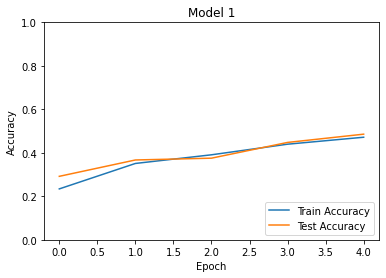

In [29]:
# evalaute model accuracy for d1
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title("Model 1")
plt.legend(loc='lower right')

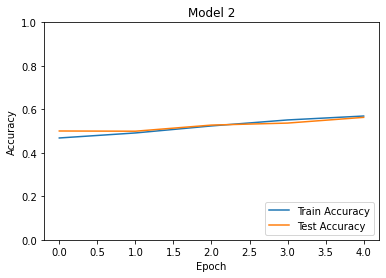

In [30]:
# evalaute model2 accuracy
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label = 'Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title("Model 2")
plt.legend(loc='lower right')

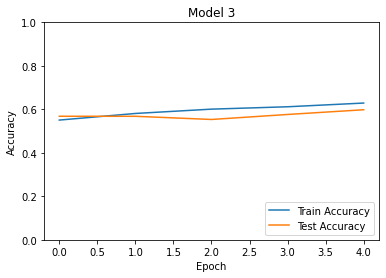

In [31]:
# evalaute model3 accuracy
plt.plot(history3.history['accuracy'], label='Train Accuracy')
plt.plot(history3.history['val_accuracy'], label = 'Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title("Model 3")
plt.legend(loc='lower right')

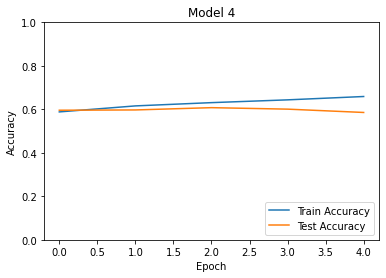

In [32]:
# evalaute model4 accuracy
plt.plot(history4.history['accuracy'], label='Train Accuracy')
plt.plot(history4.history['val_accuracy'], label = 'Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title("Model 4")
plt.legend(loc='lower right')

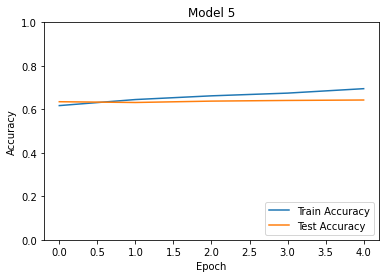

In [28]:
# evalaute model5 accuracy
plt.plot(history5.history['accuracy'], label='Train Accuracy')
plt.plot(history5.history['val_accuracy'], label = 'Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title("Model 5")
plt.legend(loc='lower right')

# Generating Prediction Vector for member subset 1

In [33]:
print('Predict on train...')
logits_train1 = model.predict(d1_data)
print('Predict on test...')
logits_test1 = model.predict(x_test)

print('Apply softmax to get probabilities from logits...')
prob_train1 = tf.nn.softmax(logits_train1, axis=-1)
prob_test1 = tf.nn.softmax(logits_test1)

print('Compute losses...')
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant

y_train_onehot = to_categorical(d1_label)
y_test_onehot = to_categorical(y_test)

loss_train = cce(constant(y_train_onehot), constant(prob_train1), from_logits=False).numpy()
loss_test = cce(constant(y_test_onehot), constant(prob_test1), from_logits=False).numpy()

index1 = 0
for p in logits_train1:
  print( p, np.argmax(p),y_test[index1])
  index1+=1

Streaming output truncated to the last 5000 lines.
[-2.2768943  -2.385416    1.3289919  -1.3736666   0.4347639   0.70441735
 -1.7023027   4.1862764  -3.8738406  -2.0776465 ] 7 [1]
[-3.5373764  -5.9620967   0.72895586  3.26796     1.8413684   2.5308704
 -0.09016925  0.94262594 -5.6374245  -4.2179327 ] 3 [2]
[-1.4432875  -4.5650196   1.4281588   2.3451614  -0.9144602   0.13494939
  1.1760697  -2.2704275  -0.6312591  -1.7884605 ] 3 [3]
[ 3.0458426  9.669096  -2.0623887 -4.344844  -4.084582  -4.13641
 -5.019032  -3.251019  -1.0532829  2.3508763] 1 [2]
[ 8.03394     2.8917732  -0.69146234 -3.6189797  -0.98336446 -6.2239704
 -6.266017   -5.033983    4.1922007  -1.9919097 ] 0 [4]
[ 0.634573   4.734251  -2.6034136 -2.4478166 -3.1546762 -3.1305003
 -1.3653437 -3.455938   1.4014282  3.447605 ] 1 [2]
[ 0.6837559  0.7547014  0.3891608 -1.9431499  1.5642394 -2.653375
 -2.7496996  1.8792372 -2.6705592 -3.40989  ] 7 [9]
[-1.074074   -0.63052815 -1.7291329   0.4981224   0.3186865  -1.973911
 -1.552540

# ATTACK on Subset 1 - Threshold attack



In [ ]:
# define what variables our attacker should have access to

attack_input = AttackInputData(
  logits_train = prob_train,
  logits_test = prob_test,
  #loss_train = loss_train,
  #loss_test = loss_test,
  labels_train =yt,
  labels_test =ys
)

In [34]:
(unique, counts) = np.unique(y_test, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[   0, 1000],
       [   1, 1000],
       [   2, 1000],
       [   3, 1000],
       [   4, 1000],
       [   5, 1000],
       [   6, 1000],
       [   7, 1000],
       [   8, 1000],
       [   9, 1000]])

In [ ]:
len(prob_train)

In [ ]:
len(yt)

In [ ]:
attack_input

In [ ]:
# how should the data be sliced
slicing_spec = SlicingSpec(
    entire_dataset = True,
    by_class = False,
    by_percentiles = False,
    by_classification_correctness = True)

In [ ]:
# define the type of attacker model that we want to use
attack_type = [
    AttackType.MULTI_LAYERED_PERCEPTRON
]

In [ ]:
len(y_train)

In [ ]:
### MMD+MiXUP - regularisation based defence
n = len(y_train)
val_samples = 2000
x_val, y_val = x_train[30000:40000], y_train[30000:40000] ### validation dataset defined


In [ ]:
print(x_val)

In [ ]:
batch_size = 128
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)


In [ ]:
len(val_ds)

In [ ]:

for images, labels in val_ds:  # only take first element of dataset
    x_val = images.numpy()
    y_val = labels.numpy()

In [ ]:
x_val

In [ ]:
y_val

In [ ]:
print(n_batches)

In [ ]:
print(n)

In [ ]:
!pip install tensorflow-model-remediation

In [ ]:
n_epochs= 10 #epochs
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
ce_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

loss_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
acc_train = np.zeros(shape=(n_epochs,), dtype=np.float32)
loss_val = np.zeros(shape=(n_epochs,))
acc_val = np.zeros(shape=(n_epochs,))

In [ ]:
from tensorflow_model_remediation import min_diff
import tensorflow as tf
mmd_loss=min_diff.losses.MMDLoss()

In [ ]:
def train_ds(new_x_train,new_y_train):
  train_ds_one = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(batch_size * 100)
    .batch(batch_size)
)
  train_ds_two = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(batch_size * 100)
    .batch(batch_size)
)
  train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))
  return train_ds

In [ ]:
def numpy_img(train_ds_mu):
  for images, labels in train_ds_mu:  # only take first element of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    #l = l.numpy()
    return numpy_images,numpy_labels

In [ ]:
#define the model 
model_mmd= define_model()#AlexnetModel(shape,num_class)
val_train_dif=30

In [ ]:
len(generator2)

In [ ]:
attacks_result_probD = mia.run_attacks(attack_input=attack_input,
                                 slicing_spec=slicing_spec,
                                 attack_types=attack_type) 